## Assignment 1: (DA6401) Introduction to Deep Learning

#### installing dependencies and setting up the wandb

In [3]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project='Backprop_From_Scratch')

In [6]:
import matplotlib.pyplot as plt 
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### Question 1(2 Marks):

In [16]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

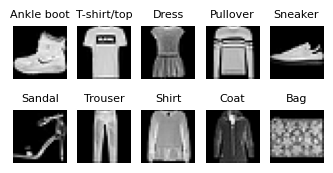

In [20]:
plotted, plot_no = [], 1
plt.figure(figsize=(4, 2))

# Initialize W&B run
wandb.init(project="backprop-from-scratch", name="plot_unique_labels")
for index, label in enumerate(train_labels): 

    if len(plotted) == len(set(train_labels)):
        break
        
    if label not in plotted: 
        plt.subplot(2, 5, plot_no)
        plt.imshow(train_images[index], cmap='grey')
        plotted.append(label)
        plt.title(f'{fashion_mnist_labels[label]}', fontsize=8)
        plt.axis("off")
        plot_no += 1

# getting the final figure
fig = plt.gcf()

#loggint the figure of wandb
wandb.log({"unique_labels_plot": wandb.Image(fig)})

plt.show()
wandb.finish()

#### Question 2(10 Marks):

In [517]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # making an update
            self.weights[i] -= dw * learning_rate
            self.biases[i] -= db * learning_rate
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numerical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [159]:
# making the data ready to train the model

# Splitting the trainig data into train and validation

indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_size = 50000
train_x = train_images[indices[:train_size]]
train_y = train_labels[indices[:train_size]]
val_x = train_images[indices[train_size:]]
val_y = train_labels[indices[train_size:]]

train_x = train_x.reshape(train_x.shape[0], -1)
val_x = val_x.reshape(val_x.shape[0], -1)

# train_x.ravel()
# val_y.ravel()

# converting y's into one hot vector
num_classes = 10
train_y = np.eye(num_classes)[train_y]
val_y = np.eye(num_classes)[val_y]

# let's do it for test data as well
test_images = test_images.reshape(test_images.shape[0], -1)
test_labels = np.eye(num_classes)[test_labels]

In [521]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10]})

In [523]:
print(wandb.config)

{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}


In [525]:

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



epoch: 0, train_loss:2.0760, val_accuracy: 0.5380
epoch: 1, train_loss:1.7583, val_accuracy: 0.6070
epoch: 2, train_loss:1.5751, val_accuracy: 0.6683
epoch: 3, train_loss:1.4275, val_accuracy: 0.6889
epoch: 4, train_loss:1.3024, val_accuracy: 0.7123
epoch: 5, train_loss:1.1972, val_accuracy: 0.7220
epoch: 6, train_loss:1.1085, val_accuracy: 0.7334
epoch: 7, train_loss:1.0324, val_accuracy: 0.7481
epoch: 8, train_loss:0.9685, val_accuracy: 0.7574
epoch: 9, train_loss:0.9135, val_accuracy: 0.7640
epoch: 10, train_loss:0.8666, val_accuracy: 0.7711
epoch: 11, train_loss:0.8257, val_accuracy: 0.7819
epoch: 12, train_loss:0.7904, val_accuracy: 0.7832
epoch: 13, train_loss:0.7597, val_accuracy: 0.7908
epoch: 14, train_loss:0.7315, val_accuracy: 0.7936
epoch: 15, train_loss:0.7079, val_accuracy: 0.7939
epoch: 16, train_loss:0.6854, val_accuracy: 0.8016
epoch: 17, train_loss:0.6657, val_accuracy: 0.8017
epoch: 18, train_loss:0.6471, val_accuracy: 0.8044
epoch: 19, train_loss:0.6320, val_accurac

In [ ]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

**Question 3(24 Marks):**

#### Optimization algorithms to implement:

- **sgd:** make update with respect to a batch of the datapoints.
- **momentum based gradient descent:** will make an update using momentum at each step.
- **nestrov accelerated gradient descent:** why not to move a little based of momentum we've.
- **rms prop:** make learning rate inversly prop to expnentionally accumulating update histroy in that particular direction.
- **adam:**
- **nadam:**

#### vanila gradient descent



In [174]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # making an update
            self.weights[i] -= dw * learning_rate
            self.biases[i] -= db * learning_rate
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numerical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [197]:
# initializing hyperparms in wandb
wandb.init(project='vanilla_gradient_descent', 
           config={ 'Learning_rate' : 0.01, 
                    'epochs' : 50000, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10]})
config.Learning_rate = 0.5
print(wandb.config)

{'Learning_rate': 0.5, 'epochs': 50, 'batch_size': 50000, 'layer_size': [784, 128, 64, 10]}


In [199]:

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

print(config.batch_size)
# passing batch size = size of the data
model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



50000
epoch: 0, train_loss:2.5263, val_accuracy: 0.1755
epoch: 1, train_loss:2.1899, val_accuracy: 0.3493
epoch: 2, train_loss:2.0400, val_accuracy: 0.4653
epoch: 3, train_loss:1.9601, val_accuracy: 0.4679
epoch: 4, train_loss:1.8783, val_accuracy: 0.5827
epoch: 5, train_loss:1.8046, val_accuracy: 0.4852
epoch: 6, train_loss:1.7489, val_accuracy: 0.5587
epoch: 7, train_loss:1.7054, val_accuracy: 0.4694
epoch: 8, train_loss:1.6741, val_accuracy: 0.5997
epoch: 9, train_loss:1.6056, val_accuracy: 0.5574
epoch: 10, train_loss:1.5576, val_accuracy: 0.5615
epoch: 11, train_loss:1.5438, val_accuracy: 0.5261
epoch: 12, train_loss:1.5140, val_accuracy: 0.5946
epoch: 13, train_loss:1.4517, val_accuracy: 0.5943
epoch: 14, train_loss:1.3844, val_accuracy: 0.6291
epoch: 15, train_loss:1.3447, val_accuracy: 0.6087
epoch: 16, train_loss:1.3231, val_accuracy: 0.6265
epoch: 17, train_loss:1.2831, val_accuracy: 0.6410
epoch: 18, train_loss:1.2440, val_accuracy: 0.6360
epoch: 19, train_loss:1.2199, val_a

In [201]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.7174


#### momentum based sgd

In [150]:
# converted the same code for sgd for momentum sgd

 
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # parameter of momentum
        self.beta = 0.90

    
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate

    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):

        weights_velocity, bias_velocity, beta = 0, 0, 0.95
        for epoch in range(epochs): 
            # First shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numberical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [152]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

print(wandb.config)

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:1.4112, val_accuracy: 0.7204
epoch: 1, train_loss:0.8460, val_accuracy: 0.7577
epoch: 2, train_loss:0.7022, val_accuracy: 0.7636
epoch: 3, train_loss:0.6540, val_accuracy: 0.7860
epoch: 4, train_loss:0.6333, val_accuracy: 0.7882
epoch: 5, train_loss:0.6228, val_accuracy: 0.7847
epoch: 6, train_loss:0.6147, val_accuracy: 0.7978
epoch: 7, train_loss:0.6110, val_accuracy: 0.7903
epoch: 8, train_loss:0.6089, val_accuracy: 0.7949
epoch: 9, train_loss:0.5990, val_accuracy: 0.7893
epoch: 10, train_loss:0.6107, val_accuracy: 0.7803
epoch: 11, train_loss:0.6105, val_accuracy: 0.7844
epoch: 12, train_loss:0.6037, val_accuracy: 0.7792
epoch: 13, train_loss:0.5969, val_accuracy: 0.7907
epoch: 14, train_loss:0.5965, val_accuracy: 0.7779
epoch: 15, train_loss:0.6075, val_accuracy: 0.7869
epoch: 16, train_loss:0.6169, val_accuracy: 0.7813
epoch: 17, train_loss:0.6178, val_accuracy: 0.7818
e

In [161]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.7657


#### NAG

In [ ]:
# converted the same code for sgd for momentum sgd

import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # parameter of momentum
        self.beta = 0.90

    
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # Computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):

            # neuron_ouputs depend on the data, which we have computed in the forward pass
            # but delta will depend on on the weight matrices
    
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate

    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):

        weights_velocity, bias_velocity, beta = 0, 0, 0.95
        for epoch in range(epochs): 
            # First shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numberical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [ ]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

print(wandb.config)

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



In [ ]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

question is how are going to compute gradient exactly at a little bit farther distance in the direction of the momentum.